# Building a Binary Classifier

> In this example, the moons dataset is used to build a binary classifier.

In [ ]:
# | hide
# Setup
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

# torch.manual_seed(0)  #  for repeatable results

# MLMVN
from mlmvn.layers import (
    FirstLayer,
    HiddenLayer,
    OutputLayer,
    cmplx_phase_activation,
    MyDropout,
)
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL
from mlmvn.process import angle2class

from res.plot_lib import set_default, plot_data, plot_loss, plot_confusion_matrix
from res.metrics import accuracy
from res.datasets import get_moons

In [ ]:
set_default()

## Dataset
In this example the moons dataset is used to build a binary classifcator. The aim is to find the boundary beetween two cresecent moons. The entire data set consists of 1500 data points and is shown in the image below. 

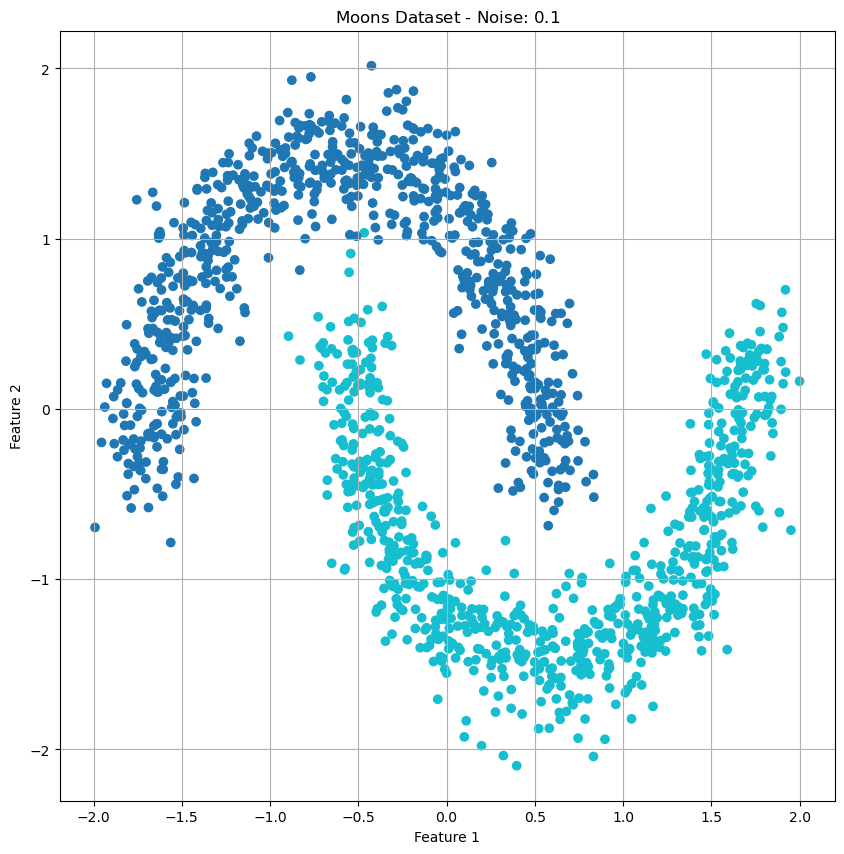

In [ ]:
# | echo: false
X, y = get_moons()
X = StandardScaler().fit_transform(X)
# X = transform(X, alpha=np.pi / 8)

plot_data(X, y)

## MLMVN

In [ ]:
def backward_hook(module, grad_input, grad_output):
    print("module:", module)
    print("grad_input:", grad_input)
    print("grad_output:", grad_output)


model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"].append(grad_output)
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = []
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"] = []
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"] = []
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"] = []
        model_dict[layer_name]["grad_output"].append(grad_output)


class MLMVN(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_linear = FirstLayer(2, 5)
        self.phase_act1 = cmplx_phase_activation()
        # self.hidden_linear = HiddenLayer(5, 5)
        # self.phase_act2 = cmplx_phase_activation()
        self.output_linear = OutputLayer(5, 1)
        self.phase_act3 = cmplx_phase_activation()

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        # x = self.hidden_linear(x)
        # x = self.phase_act2(x)
        x = self.output_linear(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def predict(self, x, loss):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return output


# Implement the train function given a training dataset X and correcsponding labels y
def train(
    model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)

            if i % 10 == 9:
                print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        y_pred = model(X)
        y_pred = angle2class(y_pred, categories, periodicity)
        scores.append(accuracy(y_pred.squeeze(), y))

        log_dict = {
            "loss": torch.tensor(losses[-1]),
            "acc": torch.tensor(scores[-1]),
        }

    return (
        losses,
        scores,
    )

In [ ]:
# | hide
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Convert numpy arrays into torch tensors
X_train_t, y_train_t, X_test_t, y_test_t = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_train_t = X_train_t.type(torch.cdouble)
X_test_t = X_test_t.type(torch.cdouble)

In [ ]:
# | hide
categories = 2
periodicity = 1
epochs = 20
batch_size = 100
lr = 1

model = MLMVN()
criterion = ComplexMSELoss.apply
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
optimizer = ECL(model.parameters(), lr=lr)

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
}

In [ ]:
# | hide
(losses, scores,) = train(
    model,
    X_train_t,
    y_train_t,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    categories=categories,
    periodicity=periodicity,
)

tensor(0.4381, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3061, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2885, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4159, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0748, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6288, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4489, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6893, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3672, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3880, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1695, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2261, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2264, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1447, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4730, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1708, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2554, dtype=torch.float64, grad

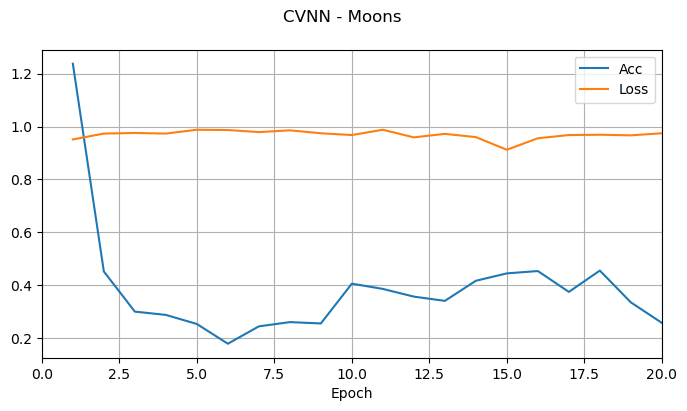

In [ ]:
# | echo: false
plot_loss("CVNN - Moons", losses, scores)

In [ ]:
# | echo: false
y_pred = model(X_train_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_train_t)
print("Train Acc.: ", acc)

Train Acc.:  0.9744444444444444


In [ ]:
# | echo: false
y_pred = model(X_test_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_test_t)
print("Test Acc.: ", acc)

Test Acc.:  0.9816666666666667


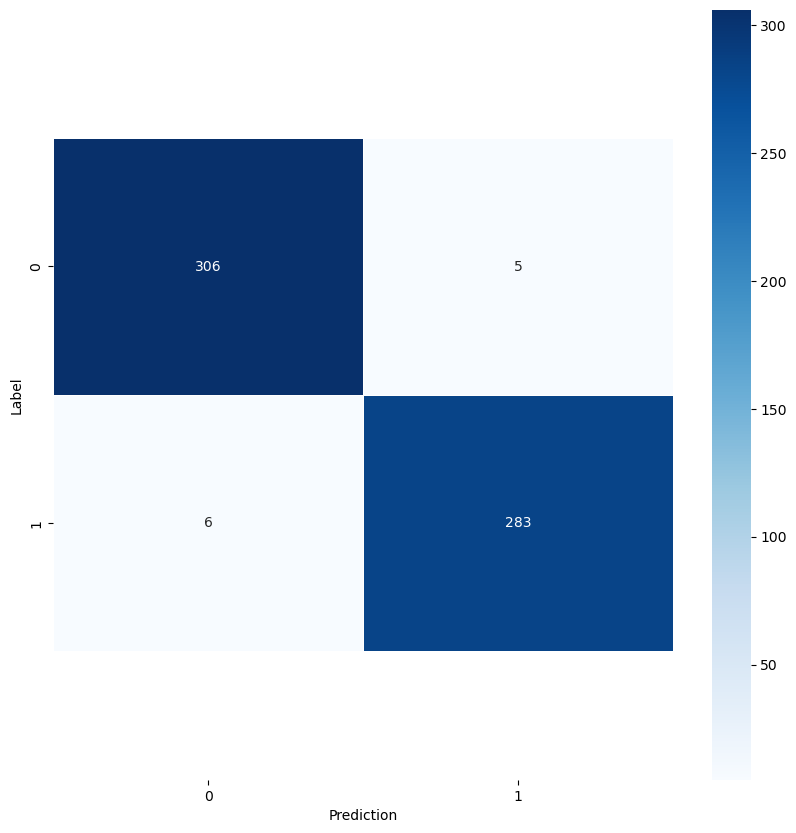

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       311
           1       0.98      0.98      0.98       289

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [ ]:
# | echo: false
plot_confusion_matrix(y_test, y_pred)